In [43]:
import torch
import torchvision
import random
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import logging

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [44]:
train=torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test=torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

### Create Imbalance MNIST dataset

In [45]:
train.data.shape

torch.Size([60000, 28, 28])

In [46]:
selection = torch.logical_or(train.targets == 2, train.targets == 7)
train.data = train.data[selection]
train.targets = train.targets[selection]


In [47]:
sample_probs = {'2':0.95, '7':0} # select 10% of 2s and 100% of 7s
idx_to_del = [i for i, label in enumerate(train.targets)  if random.random() > sample_probs[str(label.item())]]


In [48]:
train.data = train.data[idx_to_del]
train.targets = train.targets[idx_to_del].type(torch.float) # casted to float because previous loss function was only compatible with float label.
train.targets[train.targets==2] = 0
train.targets[train.targets==7] = 1
train.targets.unique(return_counts=True)

(tensor([0., 1.]), tensor([ 595, 6265]))

In [49]:
selection = torch.logical_or(test.targets == 2, test.targets == 7)
test.data = test.data[selection].type(torch.float) # select 2, 7 from test set
test.targets = test.targets[selection]

# refactor test set
test.targets[test.targets==2] = 0
test.targets[test.targets==7] = 1

### Create the network for classification

In [50]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [51]:
class Net(nn.Module): # Simple CNN to classify dataset examples
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # requires 1 channel in. 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Configurations

In [52]:
n_epochs = 50
batch_size_train = 128
batch_size_test = 500
learning_rate = 0.01
momentum = 0.5
log_interval = 10
classe_labels = np.array([2,7])
random_seed = 1
torch.backends.cudnn.enabled = False
device = 'cuda'
torch.manual_seed(random_seed)
loss_fn = nn.CrossEntropyLoss()

In [53]:
def vis(train_loss, test_accs, confusion_mtxes, labels, figsize=(7, 5)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    fig = plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.semilogy(train_loss, 'r')
    plt.ylabel('Log training loss')

    plt.subplot(1, 3, 2)
    plt.title('Test Accuracy (%)')
    plt.xlabel('Epoch')
    plt.ylabel('% accurate')
    plt.plot(test_accs, 'g')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [54]:
# SMOTE implemented w/sklearn package
import torch.utils.data as data_utils
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset
print(train.data.shape)
smote = SMOTE()
X, y = smote.fit_resample(train.data.view(len(train), -1), train.targets) # smote the dataset (must flatten to 2d first)

X = np.reshape(X, (len(X), 28, 28)) # reshape X to 3d

X_tensor = torch.from_numpy(X).view(len(X), 28, 28).float().requires_grad_(True) #.to(device) # push X to GPU and reshape
y_tensor = torch.from_numpy(y).type(torch.LongTensor) #.to(device)



train.data = X_tensor
train.targets = y_tensor



torch.Size([6860, 28, 28])


In [55]:
torch.unique(train.targets, return_counts=True)

(tensor([0, 1]), tensor([6265, 6265]))

In [56]:
# Create dataloader
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size_test, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)          


In [57]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

### Train the classifier

In [58]:
model = Net()#.to(device)
optimizer = torch.optim.SGD(model.parameters(), 0.01, 0.5)

train_loss = []
test_accs, confusion_mtxes = [], []
for epoch in range(1, n_epochs):
    model.train()
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(test_loader, position=0, leave=True) # something about this line is where the error occurs...
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data, target # Use .to(device) Transfer to GPU
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(CE=loss.item())
    model.eval()
    correct = 0
    train_loss.append(loss.item())
    targets, preds = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            _, pred = torch.max(output,dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())
    test_acc = 100. * correct / len(test_loader.dataset)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    test_accs.append(test_acc)
    confusion_mtxes.append(confusion_mtx)
    print(epoch)
    print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)


  0%|          | 0/5 [00:00<?, ?it/s]

1
Best test acc = 18.35%

  0%|          | 0/5 [00:00<?, ?it/s]

2
Best test acc = 44.47%

  0%|          | 0/5 [00:00<?, ?it/s]

3
Best test acc = 50.34%

  0%|          | 0/5 [00:00<?, ?it/s]

4
Best test acc = 51.50%

  0%|          | 0/5 [00:00<?, ?it/s]

5
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

6
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

7
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

8
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

9
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

10
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

11
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

12
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

13
Best test acc = 51.94%

  0%|          | 0/5 [00:00<?, ?it/s]

14
Best test acc = 53.20%

  0%|          | 0/5 [00:00<?, ?it/s]

15
Best test acc = 85.34%

  0%|          | 0/5 [00:00<?, ?it/s]

16
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

17
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

18
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

19
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

20
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

21
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

22
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

23
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

24
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

25
Best test acc = 90.00%

  0%|          | 0/5 [00:00<?, ?it/s]

26
Best test acc = 90.44%

  0%|          | 0/5 [00:00<?, ?it/s]

27
Best test acc = 90.97%

  0%|          | 0/5 [00:00<?, ?it/s]

28
Best test acc = 91.99%

  0%|          | 0/5 [00:00<?, ?it/s]

29
Best test acc = 91.99%

  0%|          | 0/5 [00:00<?, ?it/s]

30
Best test acc = 92.18%

  0%|          | 0/5 [00:00<?, ?it/s]

31
Best test acc = 92.33%

  0%|          | 0/5 [00:00<?, ?it/s]

32
Best test acc = 92.62%

  0%|          | 0/5 [00:00<?, ?it/s]

33
Best test acc = 92.96%

  0%|          | 0/5 [00:00<?, ?it/s]

34
Best test acc = 93.16%

  0%|          | 0/5 [00:00<?, ?it/s]

35
Best test acc = 93.74%

  0%|          | 0/5 [00:00<?, ?it/s]

36
Best test acc = 93.79%

  0%|          | 0/5 [00:00<?, ?it/s]

37
Best test acc = 93.88%

  0%|          | 0/5 [00:00<?, ?it/s]

38
Best test acc = 94.17%

  0%|          | 0/5 [00:00<?, ?it/s]

39
Best test acc = 94.42%

  0%|          | 0/5 [00:00<?, ?it/s]

40
Best test acc = 94.47%

  0%|          | 0/5 [00:00<?, ?it/s]

41
Best test acc = 94.47%

  0%|          | 0/5 [00:00<?, ?it/s]

42
Best test acc = 94.61%

  0%|          | 0/5 [00:00<?, ?it/s]

43
Best test acc = 94.81%

  0%|          | 0/5 [00:00<?, ?it/s]

44
Best test acc = 94.81%

  0%|          | 0/5 [00:00<?, ?it/s]

45
Best test acc = 94.81%

  0%|          | 0/5 [00:00<?, ?it/s]

46
Best test acc = 94.81%

  0%|          | 0/5 [00:00<?, ?it/s]

47
Best test acc = 94.81%

  0%|          | 0/5 [00:00<?, ?it/s]

48
Best test acc = 94.81%

  0%|          | 0/5 [00:00<?, ?it/s]

49
Best test acc = 94.81%

f1 score is 0.9470768902970921


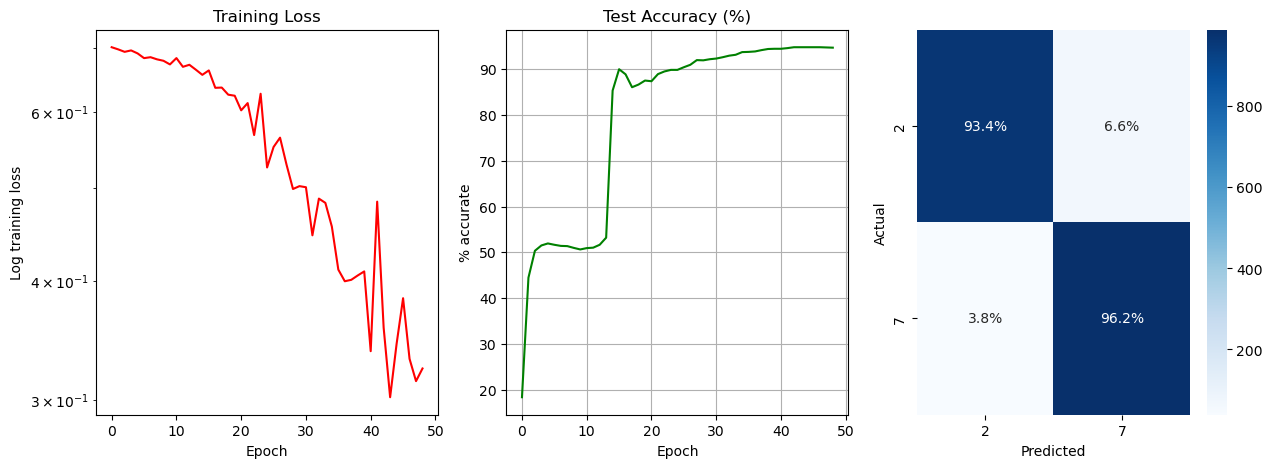

In [62]:
f1 = f1_score(targets, preds, average='macro')
print(f'f1 score is {f1}')
vis(train_loss, test_accs, confusion_mtxes, classe_labels, figsize=(15, 5))

In [60]:
train.targets.unique(return_counts=True)

(tensor([0, 1]), tensor([6265, 6265]))

f1 score is 0.9470768902970921


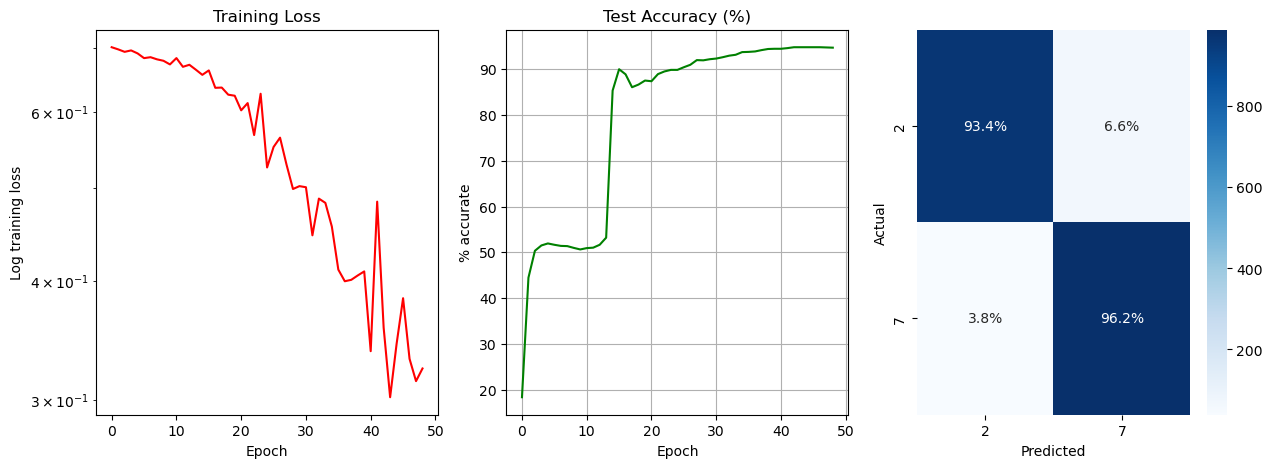

In [61]:
f1 = f1_score(targets, preds, average='macro')
print(f'f1 score is {f1}')
vis(train_loss, test_accs, confusion_mtxes, classe_labels, figsize=(15, 5))